In [4]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [6]:
from lib import models, graph, coarsening
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
from data_utils import *

Load fMRI features and behavioral labels for each block of trials per subject during cup task. The feature for each node/fMRI channel is the lowest frequency Fourier coefficient of the centered and scaled time series during a block. The labels indicate win or loss during a block. There are $209\text{ subjects} \times 4\text{ blocks}=836 \text{ samples}$ in total.

In [66]:
time_series_dir = '/Users/linggeli/Downloads/time_series/cup/'
behavioral_dir = '/Users/linggeli/Downloads/fMRIbehav/cup/'

In [80]:
subject_id_list = get_subject_id(time_series_dir)
X = get_all_features(time_series_dir, subject_id_list)
y = get_all_labels(behavioral_dir, subject_id_list)
y = (2 - y).astype(int)  # change y to a 0 or 1 integer array
print(X.shape)

(836, 375)


Randomly split the data and only use the first 100 fMRI channels for the model.

In [81]:
indices = np.random.permutation(X.shape[0])
n_train = 600

X_train = X[indices[:600], :100]
X_val = X[indices[600:800], :100]
X_test = X[indices[800:], :100]
print(X_train.shape)

y_train = y[indices[:600]]
y_val   = y[indices[600:800]]
y_test  = y[indices[800:]]

(600, 100)


Build adjacency matrix of nodes/fMRI channels based on Euclidean distance. This needs to be replaced by structural connectivity. Then the graph will be coarsened for pooling.

d = |V| = 100, k|V| < |E| = 1478


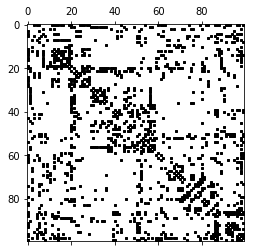

In [82]:
dist, idx = graph.distance_scipy_spatial(X_train.T, k=10, metric='euclidean')
A = graph.adjacency(dist, idx).astype(np.float32)

assert A.shape == (d, d)
print('d = |V| = {}, k|V| < |E| = {}'.format(d, A.nnz))
plt.spy(A, markersize=2, color='black');

In [83]:
graphs, perm = coarsening.coarsen(A, levels=3, self_connections=False)

X_train = coarsening.perm_data(X_train, perm)
X_val = coarsening.perm_data(X_val, perm)
X_test = coarsening.perm_data(X_test, perm)

Layer 0: M_0 = |V| = 104 nodes (4 added),|E| = 739 edges
Layer 1: M_1 = |V| = 52 nodes (1 added),|E| = 374 edges
Layer 2: M_2 = |V| = 26 nodes (0 added),|E| = 170 edges
Layer 3: M_3 = |V| = 13 nodes (0 added),|E| = 60 edges


Example model with two convolution and pooling layers.

In [84]:
params = dict()
params['dir_name']       = 'demo'
params['num_epochs']     = 10
params['batch_size']     = 20
params['eval_frequency'] = 2 * n_train / params['batch_size']

# Building blocks.
params['filter']         = 'chebyshev5'
params['brelu']          = 'b1relu'
params['pool']           = 'apool1'

# Number of classes.
C = y.max() + 1
assert C == np.unique(y).size

# Architecture.
params['F']              = [32, 64]  # Number of graph convolutional filters.
params['K']              = [20, 20]  # Polynomial orders.
params['p']              = [4, 2]    # Pooling sizes.
params['M']              = [512, C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 5e-4
params['dropout']        = 1
params['learning_rate']  = 1e-3
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['decay_steps']    = n_train / params['batch_size']

In [85]:
model = models.cgcnn(L, **params)

NN architecture
  input: M_0 = 104
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 104 * 32 / 4 = 832
    weights: F_0 * F_1 * K_1 = 1 * 32 * 20 = 640
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 26 * 64 / 2 = 832
    weights: F_1 * F_2 * K_2 = 32 * 64 * 20 = 40960
    biases: F_2 = 64
  layer 3: fc1
    representation: M_3 = 512
    weights: M_2 * M_3 = 832 * 512 = 425984
    biases: M_3 = 512
  layer 4: logits (softmax)
    representation: M_4 = 2
    weights: M_3 * M_4 = 512 * 2 = 1024
    biases: M_4 = 2


In [86]:
accuracy, loss, t_step = model.fit(X_train, y_train, X_val, y_val)

step 60 / 300 (epoch 2.00 / 10):
  learning_rate = 9.50e-04, loss_average = 1.59e+00
  validation accuracy: 69.50 (139 / 200), f1 (weighted): 69.02, loss: 1.52e+00
  time: 6s (wall 3s)
step 120 / 300 (epoch 4.00 / 10):
  learning_rate = 8.57e-04, loss_average = 1.43e+00
  validation accuracy: 64.50 (129 / 200), f1 (weighted): 64.43, loss: 1.46e+00
  time: 11s (wall 5s)
step 180 / 300 (epoch 6.00 / 10):
  learning_rate = 7.74e-04, loss_average = 1.35e+00
  validation accuracy: 70.50 (141 / 200), f1 (weighted): 70.34, loss: 1.43e+00
  time: 16s (wall 7s)
step 240 / 300 (epoch 8.00 / 10):
  learning_rate = 6.98e-04, loss_average = 1.31e+00
  validation accuracy: 69.00 (138 / 200), f1 (weighted): 69.00, loss: 1.44e+00
  time: 21s (wall 9s)
step 300 / 300 (epoch 10.00 / 10):
  learning_rate = 6.30e-04, loss_average = 1.28e+00
  validation accuracy: 67.00 (134 / 200), f1 (weighted): 66.99, loss: 1.44e+00
  time: 26s (wall 10s)
validation accuracy: peak = 70.50, mean = 68.10
